
# 4.1.5 — Pricing Rates (bases) via calcul stochastique simple

## 🎯 Objectifs
- Comprendre le pricing **basique** d’une obligation ZC via $\mathbb{E}^{\mathbb{Q}}\!\left[e^{-\int_0^T r_s ds}\right]$.
- Simuler le **taux court** $r_t$ via des modèles **simples** (drift constant, OU/Vasicek léger) pour illustrer.
- Estimer $P(0,T)$ par Monte Carlo et comparer à des cas analytiques simples.
- Lier aux objets courants : **DF**, **taux forward** $f(0,T)$ (en base simple).

---

## 1) Rappels : DF & prix ZC
- Par définition, le **discount factor** $P(0,T)$ est le prix aujourd’hui d’1€ reçu à $T$ :
  $$
  P(0,T) = \mathbb{E}^{\mathbb{Q}}\!\left[\exp\!\Big(-\int_0^T r_s\,ds\Big)\right].
  $$
- Si $r_s \equiv r$ (constant), alors $P(0,T)=e^{-rT}$.
- Le **taux simple**/instantané forward de base (définitions jouets) :
  $$
  f(0,T) := -\frac{\partial}{\partial T}\ln P(0,T).
  $$



## 2) Modèles **très simples** pour $r_t$

### 2.1 Drift constant + bruit brownien additif (jouet)
$$
dr_t = a\,dt + \sigma\, dW_t,\qquad r_0 \text{ donné.}
$$
Ce modèle peut produire des taux négatifs : **ce n’est pas un défaut ici**, on s’en sert uniquement pour **illustrer** la mécanique Monte Carlo.

### 2.2 OU (Vasicek **léger**)
$$
dr_t = k(\theta - r_t)\,dt + \sigma\, dW_t.
$$
On utilisera la **discrétisation exacte** (voir 4.1.3) pour simuler proprement.


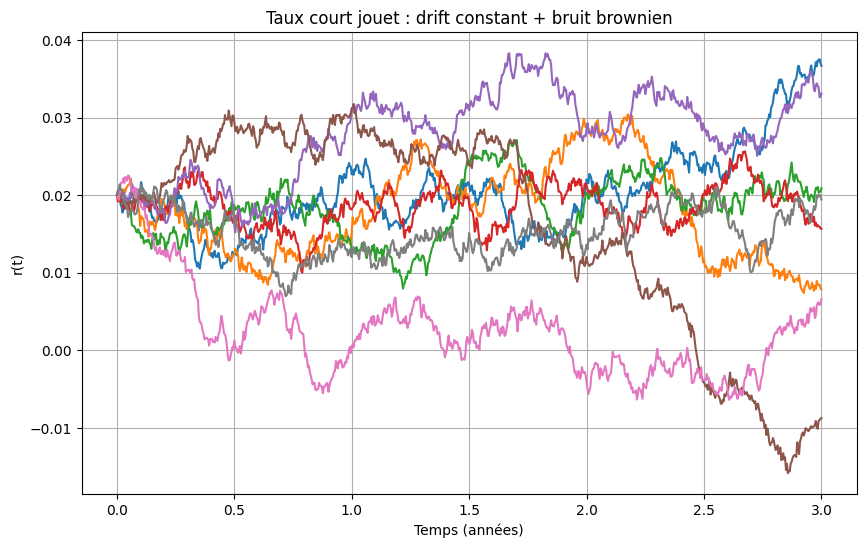

In [1]:

import numpy as np
import matplotlib.pyplot as plt

def r_paths_drift_bm(r0=0.02, a=0.0, sigma=0.01, T=5.0, N=252*5, n_paths=5, seed=0):
    rng = np.random.default_rng(seed)
    dt = T/N
    r = np.full((n_paths, N+1), r0, dtype=float)
    for i in range(N):
        z = rng.standard_normal(n_paths)
        r[:, i+1] = r[:, i] + a*dt + sigma*np.sqrt(dt)*z
    t = np.linspace(0, T, N+1)
    return t, r

t, r_sim = r_paths_drift_bm(r0=0.02, a=0.0, sigma=0.01, T=3.0, N=252*3, n_paths=8, seed=1)
plt.figure(figsize=(10,6))
for k_ in range(r_sim.shape[0]):
    plt.plot(t, r_sim[k_])
plt.title("Taux court jouet : drift constant + bruit brownien")
plt.xlabel("Temps (années)"); plt.ylabel("r(t)"); plt.grid(True); plt.show()



## 3) Pricing ZC par Monte Carlo (rectangle gauche)

On approxime l’intégrale $\int_0^T r_s\,ds$ par une somme $\sum_i r_{t_i}\Delta t$ et on moyenne :  
$$
P(0,T) \approx \frac{1}{M}\sum_{m=1}^M \exp\!\Big(-\sum_{i=0}^{N-1} r^{(m)}_{t_i}\,\Delta t\Big).
$$


In [2]:

def mc_zc_price_from_r_paths(sim_fn, T=3.0, N=252*3, M=50_000, **kwargs):
    # sim_fn doit retourner (t, r_paths) of shape (M, N+1)
    t, r = sim_fn(n_paths=M, T=T, N=N, **kwargs)
    dt = T/N
    integ = np.sum(r[:, :-1], axis=1)*dt  # rectangle gauche
    disc = np.exp(-integ)
    return disc.mean()

# Test sur modèle constant: r(t)=r0 => P(0,T)=exp(-r0*T)
def sim_r_constant(r0=0.03, T=5.0, N=252*5, n_paths=1000, seed=0):
    t = np.linspace(0,T,N+1)
    r = np.full((n_paths, N+1), r0, dtype=float)
    return t, r

for r0 in [0.01, 0.03, 0.05]:
    mc = mc_zc_price_from_r_paths(sim_r_constant, T=5.0, N=252*5, M=10000, r0=r0)
    theo = np.exp(-r0*5.0)
    print(r0, mc, theo)


0.01 0.9512294245007139 0.951229424500714
0.03 0.8607079764250578 0.8607079764250578
0.05 0.778800783071405 0.7788007830714049



## 4) Exemple avec **OU/Vasicek léger**

On réutilise la discrétisation exacte :
$$
r_{t+\Delta} = \theta + (r_t-\theta) e^{-k\Delta} + \sigma \sqrt{\frac{1-e^{-2k\Delta}}{2k}}\,Z.
$$


In [3]:

def vasicek_exact_paths(r0=0.02, k=0.5, theta=0.03, sigma=0.01, T=5.0, N=252*5, n_paths=10, seed=1):
    rng = np.random.default_rng(seed)
    dt = T / N
    r = np.full((n_paths, N+1), r0, dtype=float)
    a = np.exp(-k*dt)
    sd = sigma * np.sqrt((1 - np.exp(-2*k*dt)) / (2*k))
    for i in range(N):
        z = rng.standard_normal(n_paths)
        r[:, i+1] = theta + (r[:, i] - theta)*a + sd*z
    t = np.linspace(0, T, N+1)
    return t, r

def sim_vasicek_wrapper(**kwargs):
    return vasicek_exact_paths(**kwargs)

# Prix MC d'une ZC pour quelques maturités
T_list = [1.0, 3.0, 5.0, 10.0]
for T in T_list:
    mc = mc_zc_price_from_r_paths(sim_vasicek_wrapper, T=T, N=int(252*T), M=20000,
                                  r0=0.02, k=0.6, theta=0.03, sigma=0.012, seed=7)
    print("T=", T, " P_MC≈", mc)


T= 1.0  P_MC≈ 0.9778064195473025
T= 3.0  P_MC≈ 0.9270603760637274
T= 5.0  P_MC≈ 0.8752621950203973
T= 10.0  P_MC≈ 0.7550761027147993



## 5) Forward “instantané” (jouet) et intuition

À partir de $P(0,T)$ simulé, on peut approximer un **taux forward instantané** par dérivée numérique :  
$$
f(0,T) \approx -\frac{\ln P(0,T+\delta)-\ln P(0,T)}{\delta}.
$$
On le trace pour une grille de maturités (illustration, pas de calibration “marché” ici).


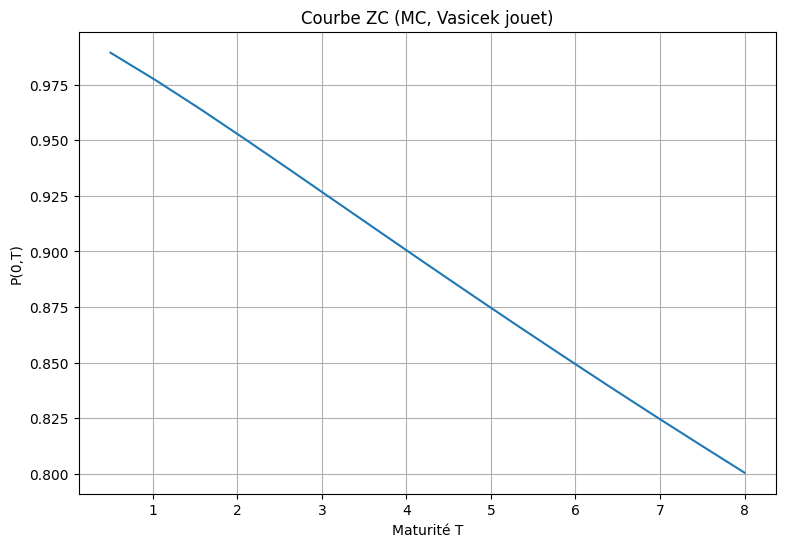

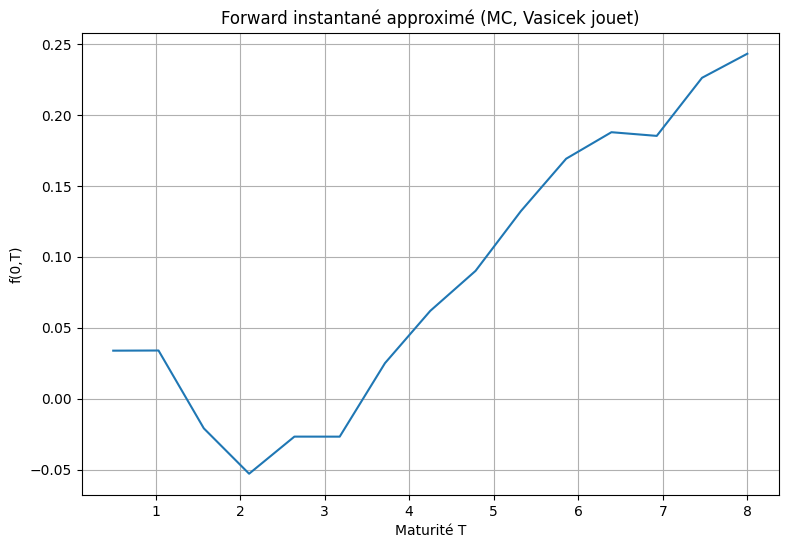

In [4]:

import numpy as np
import matplotlib.pyplot as plt

def mc_curve(sim_fn, T_max=10.0, nT=25, delta=1e-3, **kwargs):
    Ts = np.linspace(0.5, T_max, nT)
    P = np.array([mc_zc_price_from_r_paths(sim_fn, T=T, N=int(252*T), M=10000, **kwargs) for T in Ts])
    # forward approx
    P_plus = np.array([mc_zc_price_from_r_paths(sim_fn, T=T+delta, N=int(252*(T+delta)), M=8000, **kwargs) for T in Ts])
    f = -(np.log(P_plus)-np.log(P))/delta
    return Ts, P, f

Ts, Pj, fj = mc_curve(sim_vasicek_wrapper, T_max=8.0, nT=15, r0=0.02, k=0.6, theta=0.03, sigma=0.012, seed=9)

plt.figure(figsize=(9,6))
plt.plot(Ts, Pj)
plt.title("Courbe ZC (MC, Vasicek jouet)"); plt.xlabel("Maturité T"); plt.ylabel("P(0,T)"); plt.grid(True); plt.show()

plt.figure(figsize=(9,6))
plt.plot(Ts, fj)
plt.title("Forward instantané approximé (MC, Vasicek jouet)"); plt.xlabel("Maturité T"); plt.ylabel("f(0,T)"); plt.grid(True); plt.show()



---

## 📌 À retenir
- **Idée de base** : $P(0,T)=\mathbb{E}^{\mathbb{Q}}[\exp(-\int_0^T r_s ds)]$ ; on peut l’estimer par **Monte Carlo** dès qu’on sait simuler $r_t$.
- **Modèles jouets** utiles pour apprendre** : drift + bruit additif, OU (Vasicek) avec simulation exacte.
- Les **courbes** $P(0,T)$ et **forwards** se dérivent **numériquement** d’un MC si besoin.

## ✍️ Exercices (simples mais utiles)
1. Sous le modèle **drift+bruit** avec $a=0$, montrer que $\mathbb{E}[r_t]=r_0$ et vérifier numériquement.  
2. Reprendre l’estimation de $P(0,T)$ en utilisant **trapèzes** au lieu de rectangle gauche pour $\int r_s ds$ et comparer.
3. (Bonus) Sous Vasicek, comparer $P(0,T)$ **MC** avec la **formule fermée** donnée dans le 4.1.3.
